# Analyzing Experimental Data pty-co-SAXSNN

## Import necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

from pathlib import Path
import torch
import sys
import os

import importlib
import tifffile
import pandas as pd

import scipy.io as sio

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))
from utils.analyzer import DiffractionAnalyzer

## Load experimental data for analysis

In [2]:
# Set paths
sample_dir='ZCB_9_3D_'
base_directory='/net/micdata/data2/12IDC/2025_Feb/'


# Read the file, skipping the first row (which starts with #) and using the second row as headers
df = pd.read_csv(f'{base_directory}misc/{sample_dir}/ZCB9_3D_alignment_shifts_28nm.txt', 
                 comment='#',  # Skip lines starting with #
                 names=['Angle', 'y_shift', 'x_shift', 'scanNo'])  # Specify column names

# Convert scanNo to integer if needed
df['scanNo'] = df['scanNo'].astype(int)

# # Sort by angle and find scans at roughly 45-degree increments
# target_angles = np.arange(8, 9, 1)
# selected_scans = []
# for target in target_angles:
#     # Find the scan with angle closest to target
#     closest_scan = df.iloc[(df['Angle'] - target).abs().argsort()[:1]]
#     selected_scans.append({
#         'scan': int(closest_scan['scanNo'].iloc[0]),
#         'angle': closest_scan['Angle'].iloc[0],
#         'shift_y': closest_scan['y_shift'].iloc[0],
#         'shift_x': closest_scan['x_shift'].iloc[0]
#     })

# # Print selected scans for reference
# print("Selected scans for analysis:")
# for scan in selected_scans:
#     print(f"Angle: {scan['angle']:.1f}°, Scan: {scan['scan']}, Shifts (x,y): ({scan['shift_x']:.2f}, {scan['shift_y']:.2f})")

## Load and plot example object and probe from scan

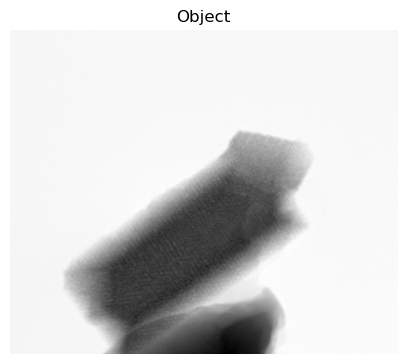

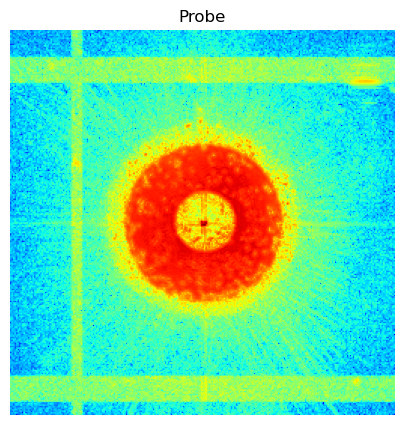

In [3]:
# Scan information
scan_number=5065
ncols=36
nrows=29
center=(517,575)
dp_size=(1043,981)
center_offset_y=dp_size[0]//2-center[0]
center_offset_x=dp_size[1]//2-center[1]

# Model path
model_path = Path('/net/micdata/data2/12IDC/ptychosaxs/batch_mode_250/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_25_pearson_loss_symmetry_0.0.pth')

# Load and display the object for visualization (tiff file)
obj=tifffile.imread(f"{base_directory}results/{sample_dir}/fly{scan_number}/roi0_Ndp256/MLc_L1_p10_gInf_Ndp128_mom0.5_pc0_maxPosError500nm_bg0.1_vi_mm/MLc_L1_p10_g100_Ndp256_mom0.5_pc800_maxPosError500nm_bg0.1_vp4_vi_mm/O_phase_roi/O_phase_roi_Niter1000.tiff")
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.set_title('Object')
ax.imshow(obj,cmap='gray')
ax.axis('off')
plt.show()

# Load and display the probe
ob=sio.loadmat(f"{base_directory}results/{sample_dir}/fly{scan_number}/roi0_Ndp256/MLc_L1_p10_gInf_Ndp128_mom0.5_pc0_maxPosError500nm_bg0.1_vi_mm/MLc_L1_p10_g100_Ndp256_mom0.5_pc800_maxPosError500nm_bg0.1_vp4_vi_mm/Niter1000.mat")
pb=ob['probe']

# Only first mode
pb1=pb[:,:,0,0]
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.set_title('Probe')
ax.imshow(np.abs(np.fft.fftshift(np.fft.fft2(pb1))),cmap='jet',norm=colors.LogNorm())
ax.axis('off')
plt.show()

## Initialize ```DiffractionAnalyzer``` object used for deconvolution

In [4]:
# Initialize the analyzer
analyzer = DiffractionAnalyzer(
        base_path=f'{base_directory}/ptycho/',
        scan_number=scan_number,
        dp_size=256,
        center_offset_y=center_offset_y,
        center_offset_x=center_offset_x
)

## Load model, perform deconvolution, and record time

In [5]:
# Load and process data
analyzer.load_and_crop_data()
# Load model
analyzer.load_model(model_path=model_path,gpu_index=None)
# Make sure you're on GPU
device = analyzer.model.device
# Create start and end events
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)
# Start timing
start_event.record()
# Perform deconvolution
analyzer.perform_deconvolution()
# End timing
end_event.record()
# Wait for the events to be recorded
torch.cuda.synchronize()
# Compute elapsed time in milliseconds
elapsed_time_ms = start_event.elapsed_time(end_event)
print(f"Elapsed time: {elapsed_time_ms:.3f} ms")

100%|██████████| 1044/1044 [00:08<00:00, 125.18it/s]


Let's use 4 GPUs!
Elapsed time: 11292.565 ms


## Load probe into ```DiffractionAnalyzer```

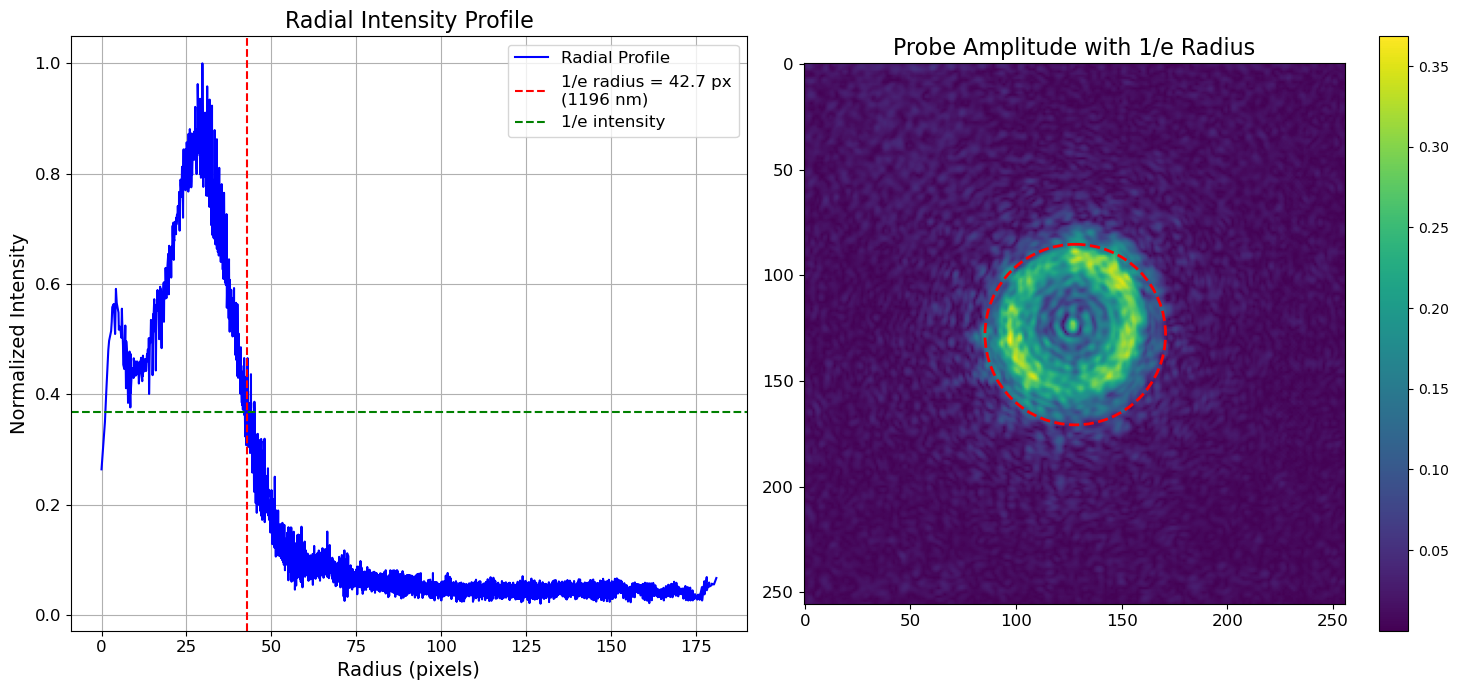

42.720018726587654

In [ ]:
# Load probe
analyzer.load_probe(pb1)
# Calculate probe radius
analyzer.calculate_probe_radius(show_fit=True)

## Plot overlay scans for preprocessed, deconvoled, and sample FFT

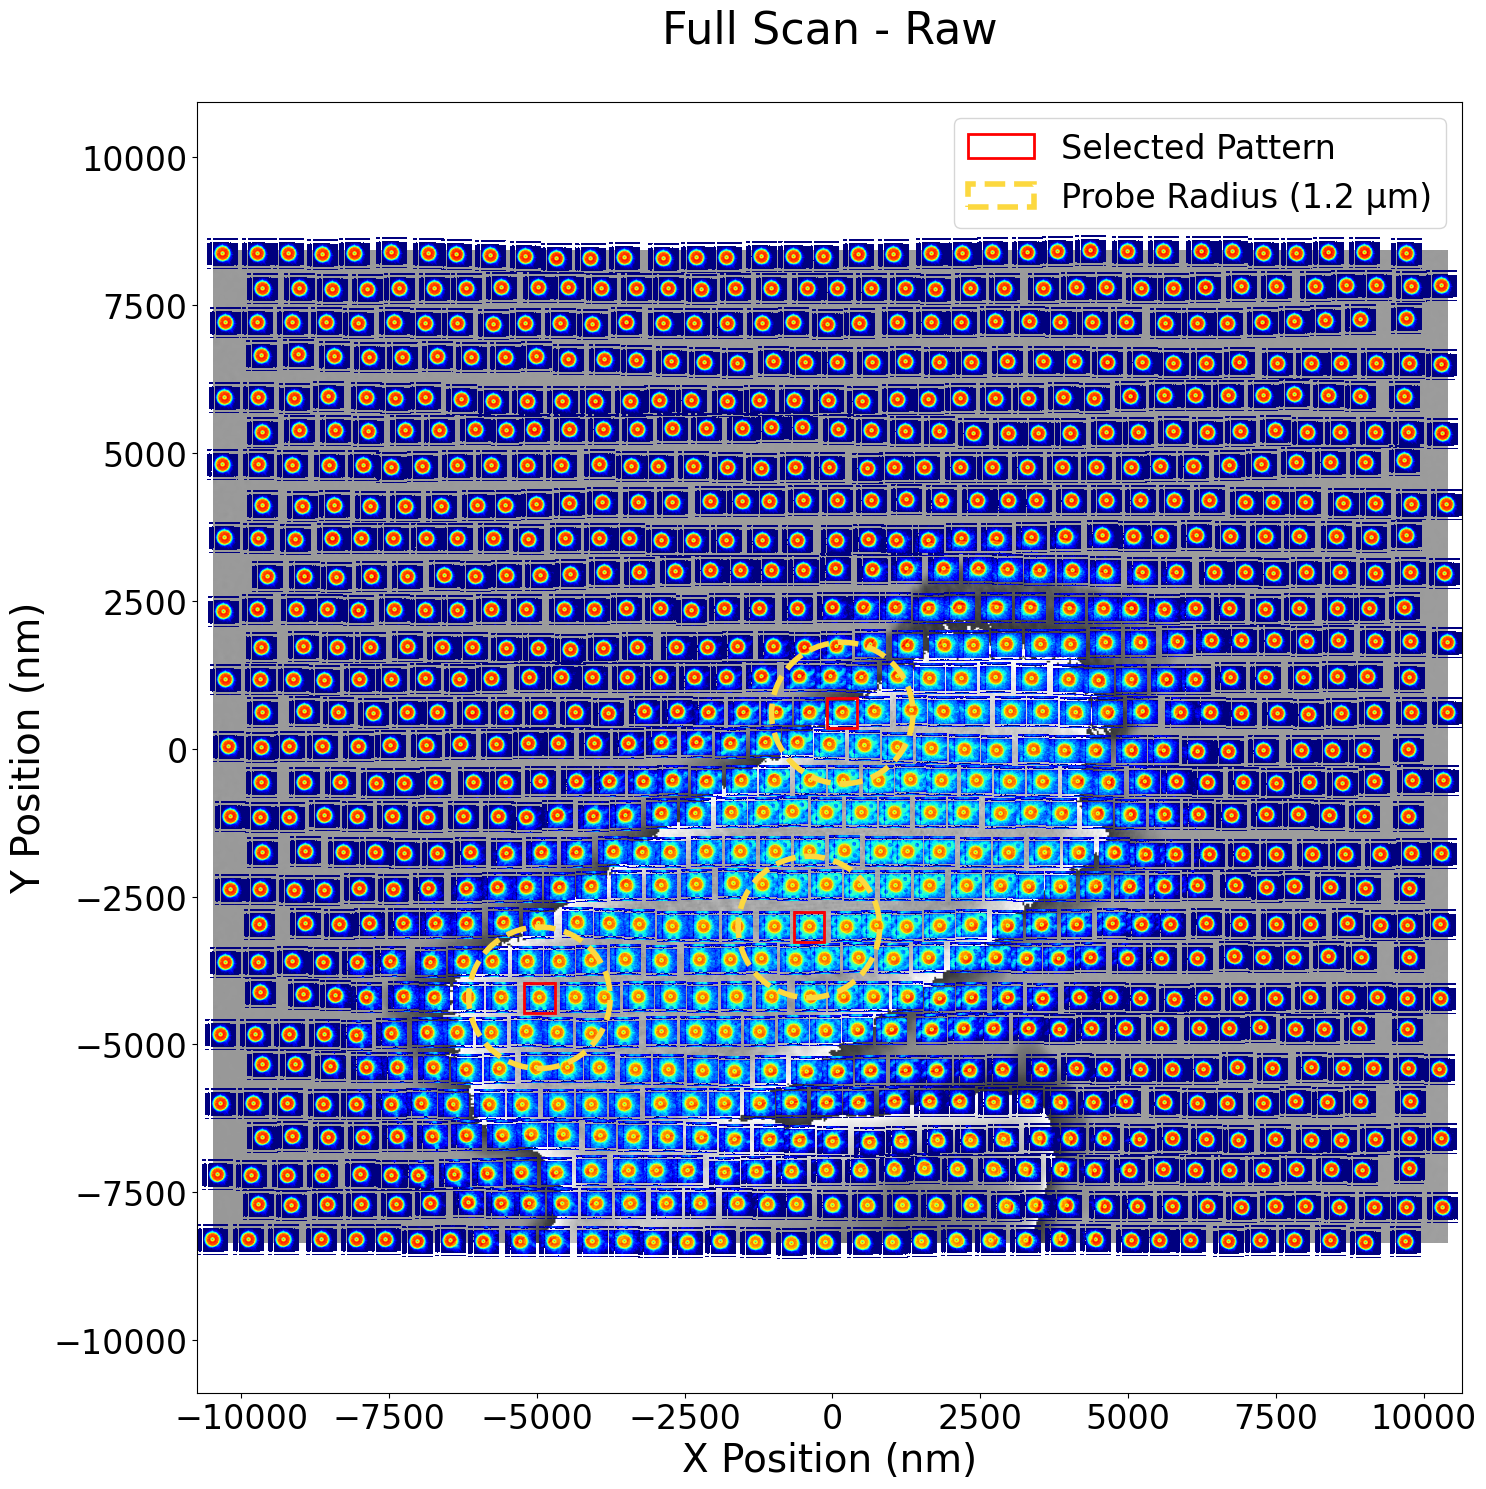

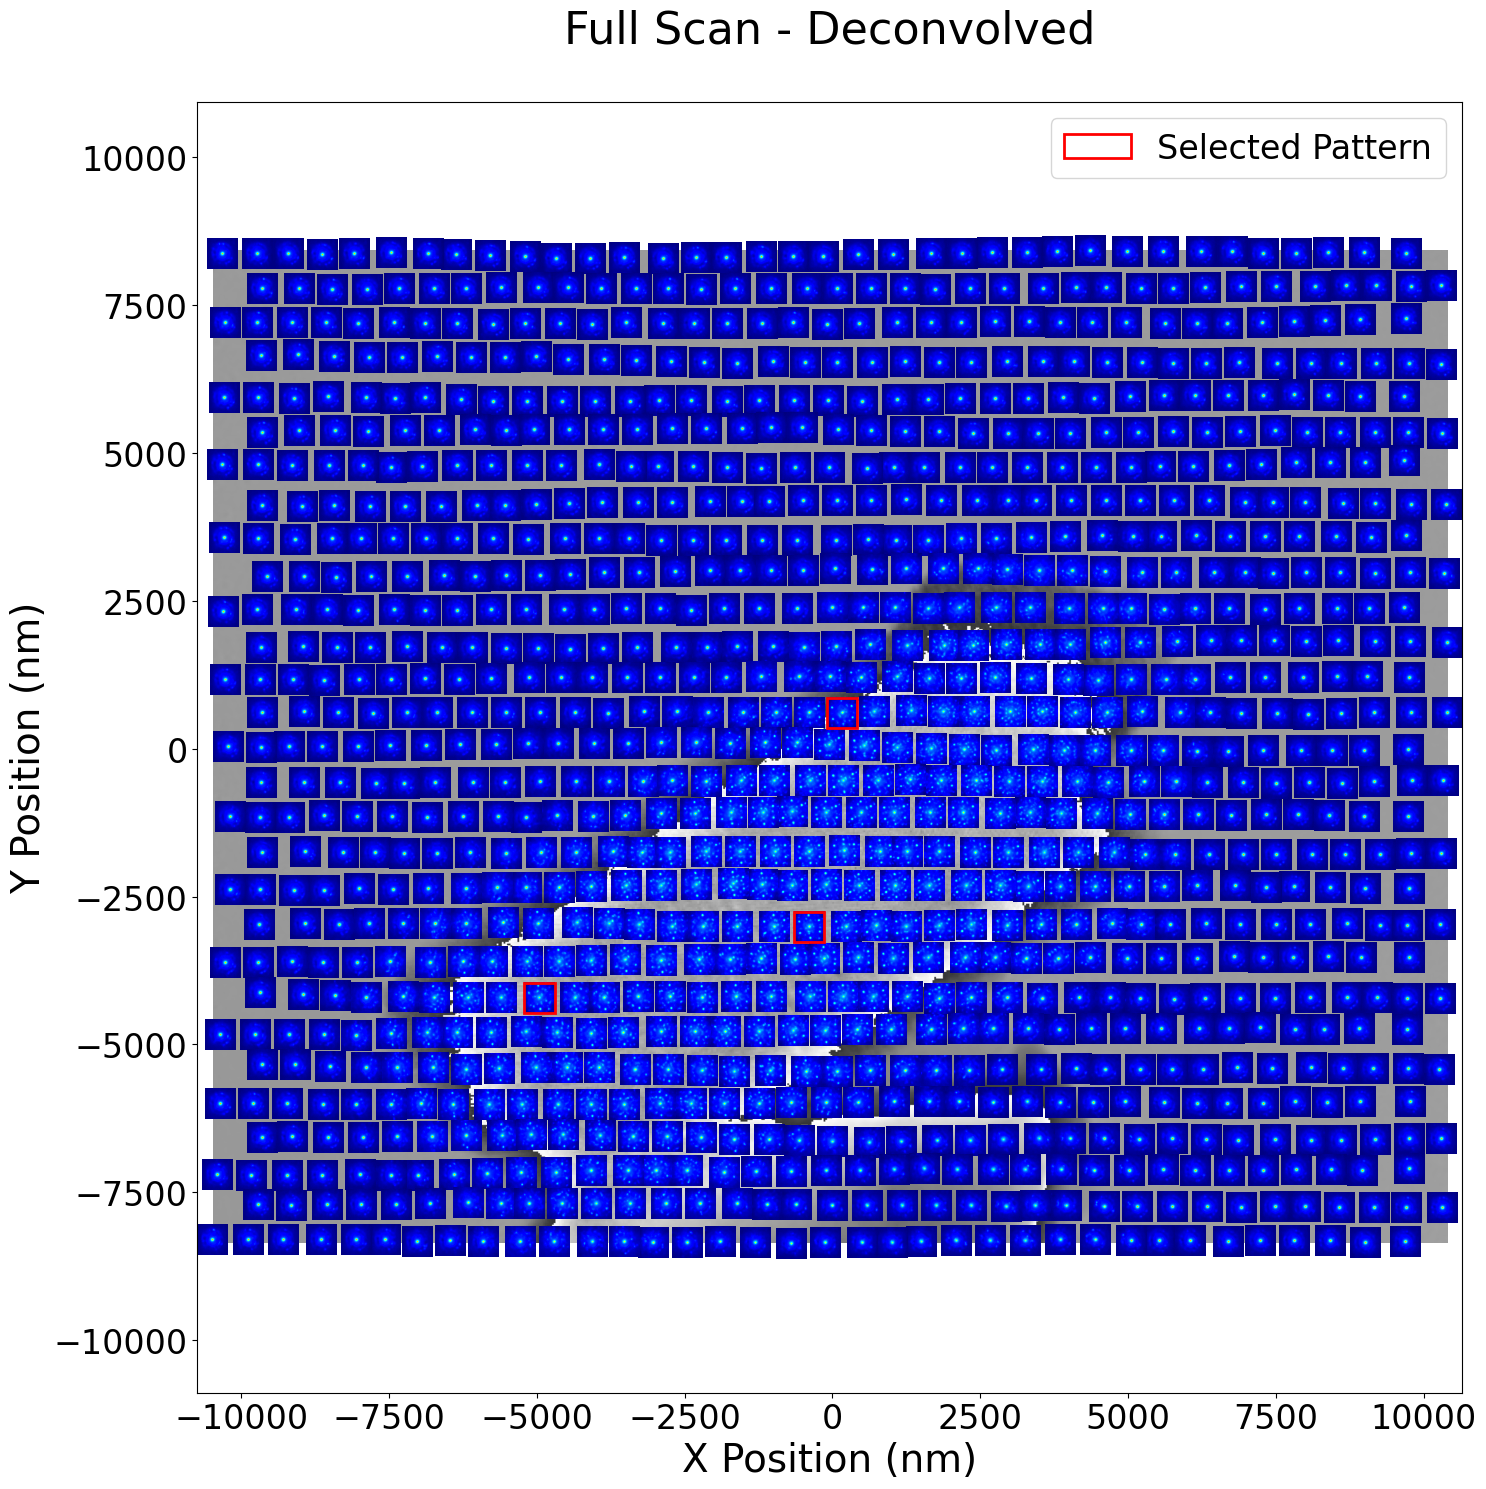

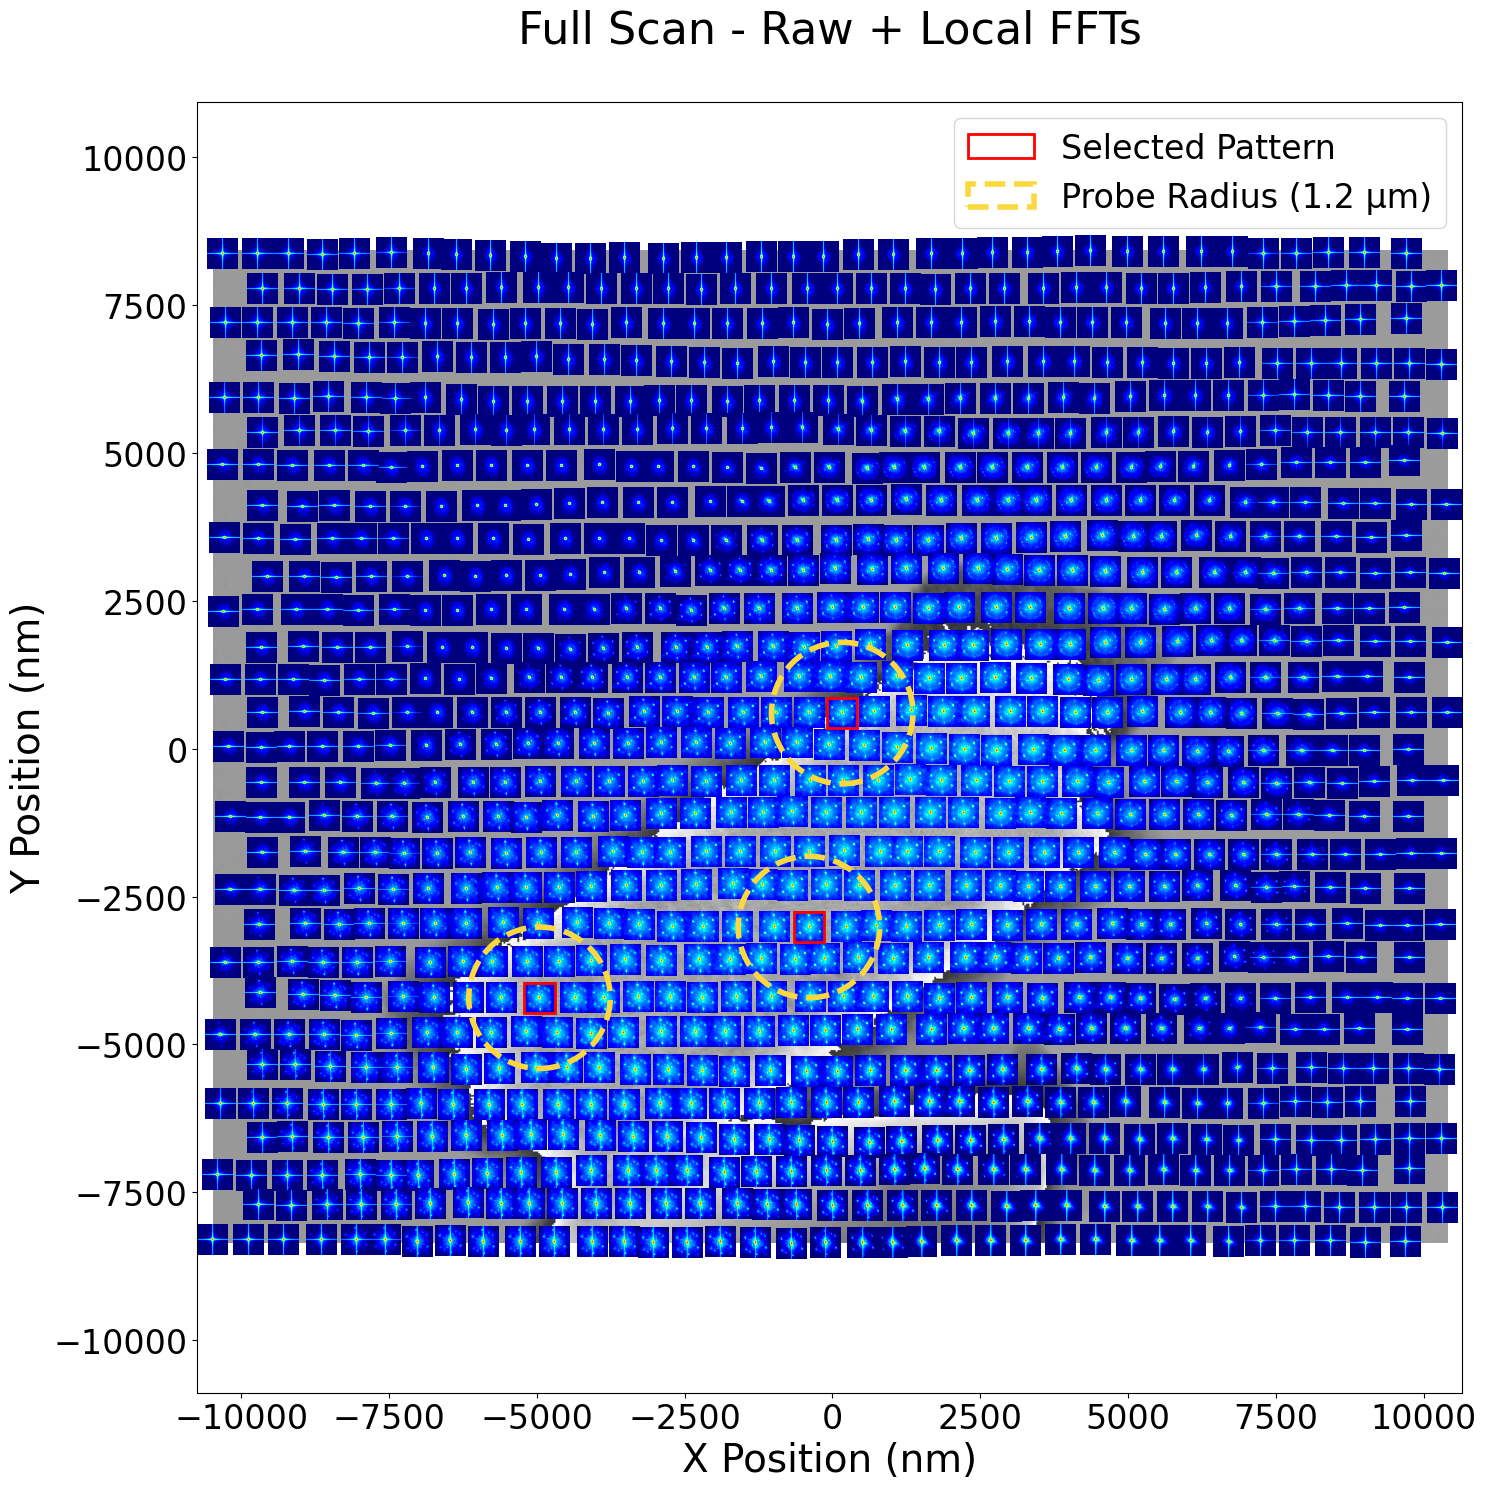

In [ ]:
highlight_indices=[700,485,764]
# Plot original scan overlay
analyzer.plot_scan_overlay(
    highlight_indices=highlight_indices,
    use_corrected_positions=False,
    use_deconvolved=False,
    scale_factor=2,
    show_probe_size=True,
    save_path=f"../example/04_Inference_Experimental/plots/{sample_dir}scan_overlay_original_{analyzer.scan_number}.pdf"
    )

# Plot deconvolved scan overlay
analyzer.plot_scan_overlay(
    highlight_indices=highlight_indices,
    use_corrected_positions=False,
    use_deconvolved=True,
    scale_factor=2,
    show_probe_size=False,
    save_path=f"../example/04_Inference_Experimental/plots/{sample_dir}scan_overlay_deconvolved_{analyzer.scan_number}.pdf"
    )

# Calculate local FFTs
analyzer.calculate_local_ffts(use_corrected_positions=False,vignette=True)
# Plot with local FFTs
analyzer.plot_scan_overlay(
    use_deconvolved=False,
    scale_factor=2,
    use_corrected_positions=False,
    highlight_indices=highlight_indices,
    vignette_fft=True,
    show_probe_size=True,
    show_local_fft=True,
    save_path=f"../example/04_Inference_Experimental/plots/{sample_dir}scan_overlay_local_fft_{analyzer.scan_number}.pdf"
)

## Plot hightlighted diffraction patterns

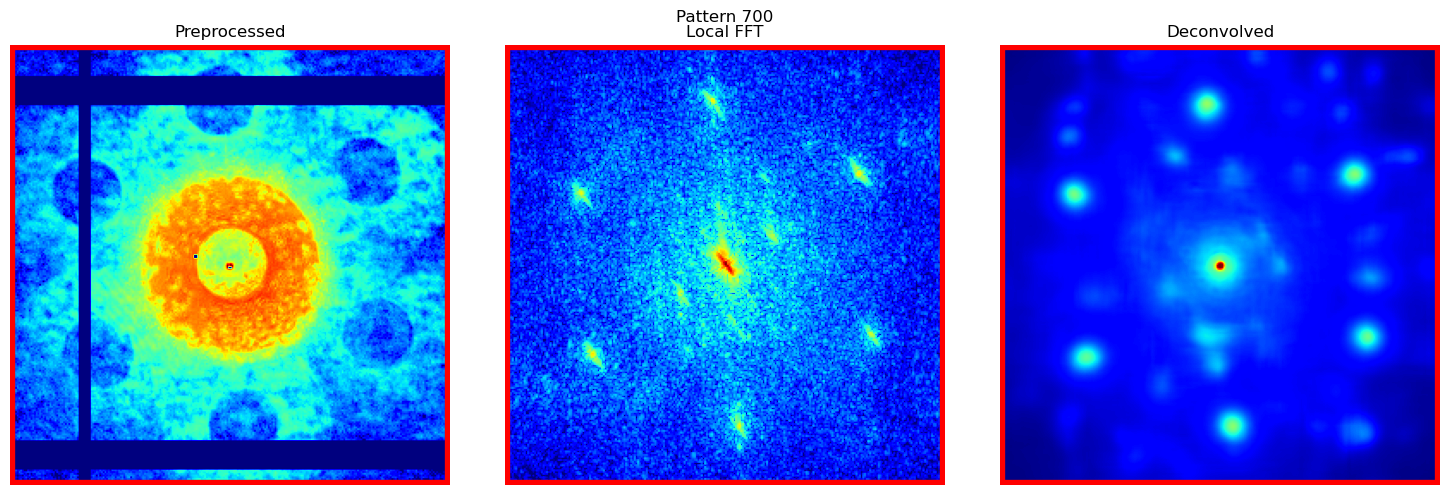

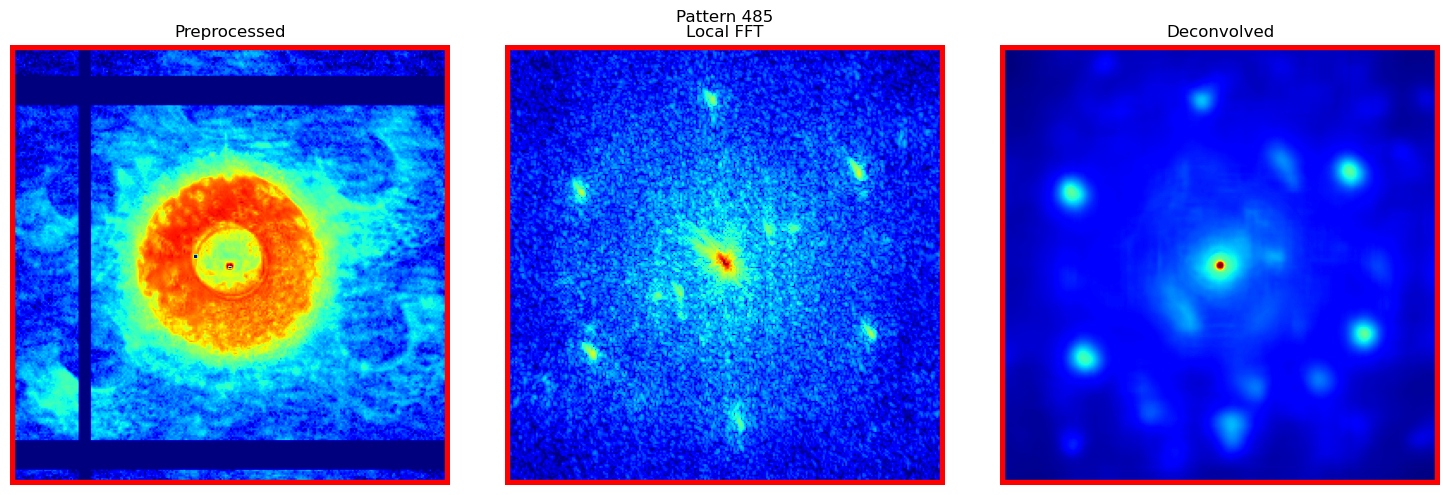

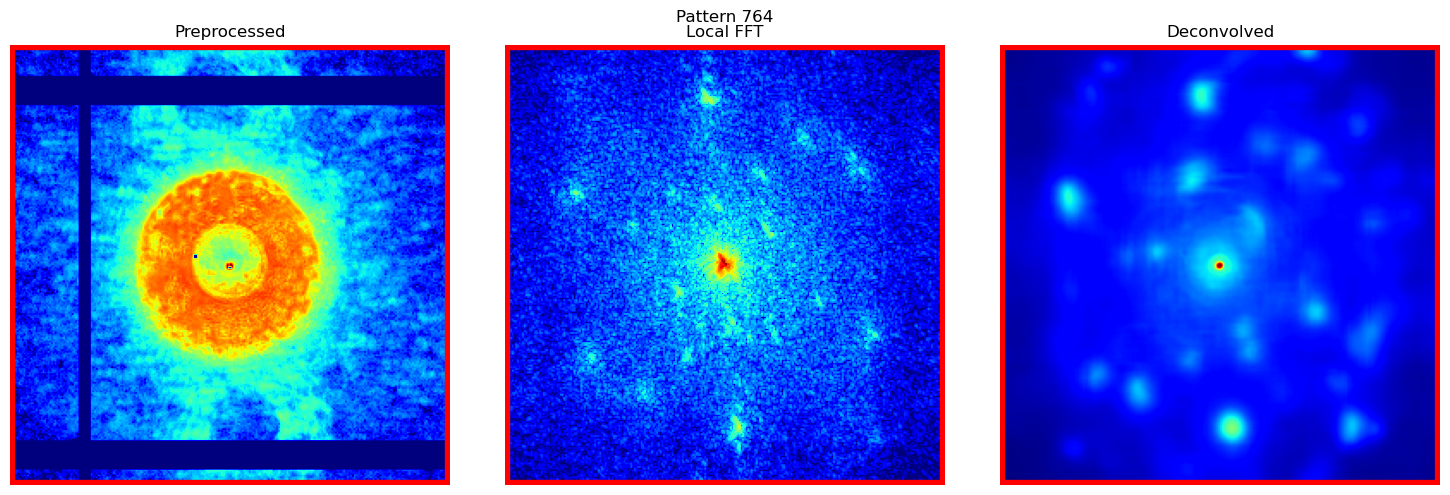

In [8]:
# Visualize example patterns
for i in highlight_indices:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Pattern {i}')
    
    # Preprocessed pattern
    axes[0].imshow(analyzer.preprocessed_patterns[i])
    axes[0].set_title('Preprocessed')
    axes[0].axis('off')
    pattern_size = 255
    rect = plt.Rectangle((0, 0), 
                        pattern_size, pattern_size,
                        fill=False, color='red', linewidth=6,
                        label=f'Selected Pattern (Index: {i})')
    axes[0].add_patch(rect)
    
    # Local FFT
    axes[1].imshow(np.abs(analyzer.local_ffts[i])**2, norm=colors.LogNorm(vmin=1e1))
    axes[1].set_title('Local FFT')
    axes[1].axis('off')
    rect = plt.Rectangle((0, 0), 
                        pattern_size, pattern_size,
                        fill=False, color='red', linewidth=6,
                        label=f'Selected Pattern (Index: {i})')
    axes[1].add_patch(rect)
    
    # Deconvolved pattern
    axes[2].imshow(analyzer.deconvolved_patterns[i])
    axes[2].set_title('Deconvolved')
    axes[2].axis('off')
    rect = plt.Rectangle((0, 0), 
                        pattern_size, pattern_size,
                        fill=False, color='red', linewidth=6,
                        label=f'Selected Pattern (Index: {i})')
    axes[2].add_patch(rect)
    
    plt.tight_layout()
    plt.show()


## Extract sample indices corresponding to sample area from scan

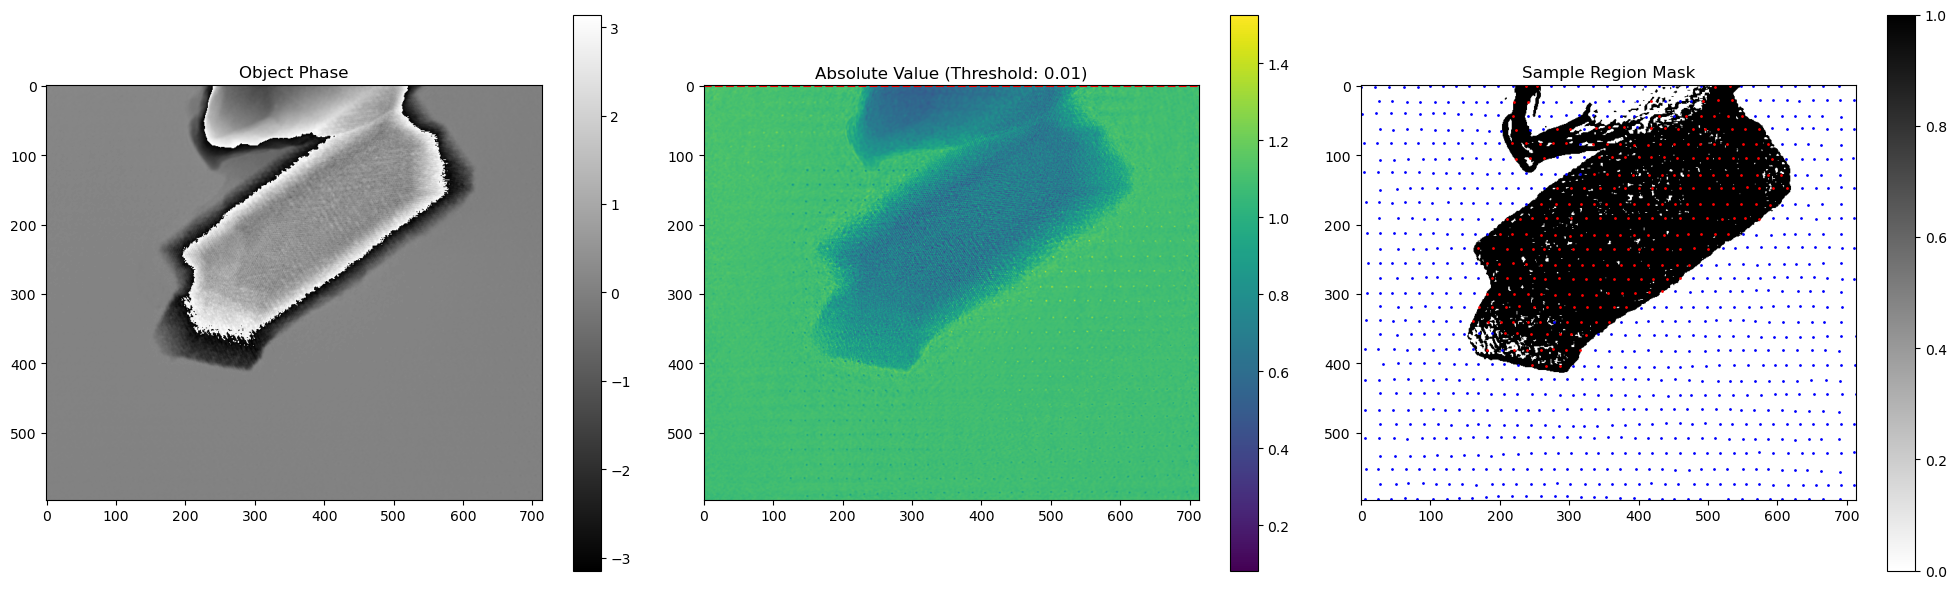

Found 259 patterns over the sample region
Pattern indices: [ 335  336  337  379  380  381  382  383  384  386  405  406  407  408
  409  410  411  449  450  451  452  454  455  456  457  458  459  475
  476  477  478  479  480  481  482  483  484  485  486  517  518  519
  520  521  522  523  524  525  526  527  528  529  530  548  549  550
  551  552  553  554  555  556  557  558  559  560  561  562  587  588
  589  590  591  592  593  594  595  596  597  598  599  600  601  602
  619  620  621  622  623  624  625  626  627  628  629  630  631  632
  633  634  635  636  656  657  658  659  660  661  662  663  664  665
  666  667  668  669  670  671  672  673  693  694  695  696  697  698
  699  700  701  702  703  704  705  706  707  708  709  710  711  712
  725  726  727  728  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  769  770  771  772  773  774  775  776  777  778
  779  780  781  782  783  784  785  786  796  797  798  799  800  801
  802  803  804  8

In [9]:
# Variance threshold
patterns, indices = analyzer.extract_sample_patterns(mask_type='variance', 
                                                     variance_window=5, 
                                                     variance_threshold=0.01,
                                                     show_mask=True,
                                                     use_deconvolved=True)

# You can then use these patterns for further analysis
print(f"Found {len(patterns)} patterns over the sample region")
print(f"Pattern indices: {indices}")

## Process all scan_numbers to find sample area

In [10]:
# Define your scan parameters
base_path = f'{base_directory}/ptycho/'
dp_size = 256
scan_numbers = [5065]

#Process all scans and save indices
indices = DiffractionAnalyzer.process_multiple_scans(
    scan_numbers=scan_numbers,#df['scanNo'].values.tolist(),
    base_path=base_path,
    dp_size=dp_size,
    center_offset_y=center_offset_y,
    center_offset_x=center_offset_x,
    output_file=f'../example/04_Inference_Experimental/{sample_dir}{scan_numbers[0]}_sample_indices_variance_threshold.h5',
    show_mask=False  # Set to True if you want to see the mask for each scan
)


Processing scan 5065 (1/1)


100%|██████████| 1044/1044 [00:08<00:00, 126.62it/s]


Using variance mask
Found 259 sample patterns for scan 5065
Saved results for scan 5065 to ../example/04_Inference_Experimental/ZCB_9_3D_5065_sample_indices_variance_threshold.h5 and backup

Completed processing 1 out of 1 scans
Results saved to ../example/04_Inference_Experimental/ZCB_9_3D_5065_sample_indices_variance_threshold.h5
Backup saved to ../example/04_Inference_Experimental/ZCB_9_3D_5065_sample_indices_variance_threshold_20251121_081106_backup.h5


## Load in sample indices from multiple scan process result

In [11]:
# Later, you can load the indices from the file
loaded_indices = DiffractionAnalyzer.load_sample_indices(f'../example/04_Inference_Experimental/{sample_dir}{scan_numbers[0]}_sample_indices_variance_threshold.h5')

# Print some information about the loaded indices
for scan_number, scan_indices in loaded_indices.items():
    print(f"Scan {scan_number}: {len(scan_indices)} sample patterns")

Scan 5065: 259 sample patterns
